In [23]:
import pandas as pd
import numpy as np

# Tweets

In [11]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pickle

import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')

from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import re


from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
data_ori = pd.read_pickle('../data/Bitcoin_tweets_sample.pkl')
data_ori.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,Tino@tradersreality,"England, United Kingdom",Allow me to introduce to you the hardest easie...,2017-06-17 00:05:04,22061.0,173.0,2147.0,False,2021-10-19 15:20:31,Who loves a good old Stop Hunt from our belove...,"['bitcoin', 'CryptoNews']",Twitter Web App,False
1,onemorecomma,StackSats™️,"Early to Bitcoin, late to Twitter",2021-07-28 11:43:39,227.0,351,20865,False,2021-10-21 22:26:28,Suddenly a wild bear market appeared...\n\n#bi...,['bitcoin'],Twitter for iPhone,False
2,Winners traders,United Kingdom,"Real Binance Futures Trading Signal, join my f...",2011-11-26 16:09:20,244.0,124.0,63.0,False,2021-07-29 07:02:45,We give the best signals on binance futures. J...,"['BTC', 'cryptotrading', 'Binance', 'BinanceFu...",Twitter for Android,False
3,Banks Shilton 💎 Elite 💎,NaN,The Premier Marketing Force in the Crypto Vers...,2021-08-09 19:17:31,94.0,153.0,1489.0,False,2021-08-24 00:58:00,@TimmyTimX2 @MXStoken TG https://t.co/AQTHidcD...,"['MXS', 'ETH', 'ethereum', 'doge', 'BTC', 'Bit...",Twitter Web App,False
4,Fayenutbutter,earth,Tweets anything. | 🐺 | https://t.co/OZOvcpOcLu,2018-08-31 07:29:30,253.0,786,4359,False,2021-07-27 08:07:45,@CryptoMichNL my eyes are glued to #HXN @Haven...,"['HXN', 'HXN', 'BTC', 'HXN']",Twitter for Android,False


In [5]:
#clean the dataframe, drop the rows where the "text" and 'hashtags' columns are NaN
data_clean = data_ori.dropna(subset=['text','hashtags']).reset_index(drop=True)
# get only texts
text_data = data_clean[['text']].copy() 
text_data.columns = ['tweets']
# show the data
print(text_data.shape)
text_data.head()

(16757, 1)


,tweets
0,Who loves a good old Stop Hunt from our belove...
1,Suddenly a wild bear market appeared...\n\n#bi...
2,We give the best signals on binance futures. J...
3,@TimmyTimX2 @MXStoken TG https://t.co/AQTHidcD...
4,@CryptoMichNL my eyes are glued to #HXN @Haven...


In [6]:
lemmatizer = WordNetLemmatizer()
# Import nltk stopwords and customize it to add common crypto words that don't add too much information 
stop_words = stopwords.words(['english'])
crypto_words = ['btc','bitcoin','eth','etherum','crypto']
stop_words = stop_words + crypto_words

In [7]:
# create a function to clean the tweets
def text_clean(data):
  #I.  
  #1. Remove urls/hyperlinks
  tweet_without_url = re.sub(r'((www\.[^\s]+)|(http\S+))',' ', data)

  #2. Remove hashtags
  tweet_without_hashtag = re.sub(r'#\w+', ' ', tweet_without_url)

  #3. Remove mentions 
  tweet_without_mentions = re.sub(r'@\w+',' ', tweet_without_hashtag)

  #4. Remove characters that not in the English alphabets
  tweet_pre_cleaned = re.sub('[^A-Za-z]+', ' ', tweet_without_mentions)
  
  #5. Remove additional white spaces
  tweet_pre_cleaned = re.sub('[\s]+', ' ', tweet_pre_cleaned)
    
  #II. 
    #1. Tokenize
  tweet_tokens = TweetTokenizer().tokenize(tweet_pre_cleaned)

    #2. Lower?
  tweet_lower = [l.lower() for l in tweet_tokens]

    #2. Remove Puncs
  tokens_without_punc = [w for w in tweet_lower if w.isalpha()]
    
    #3. Removing Stopwords
  lemmatizer = WordNetLemmatizer()
    # Import nltk stopwords and customize it to add common crypto words that don't add too much information 
  stop_words = stopwords.words(['english'])
  crypto_words = ['btc','bitcoin','eth','etherum','crypto']
  stop_words = stop_words + crypto_words
  tokens_without_stopwords = [t for t in tokens_without_punc if t not in stop_words]
    
    #4. lemmatize
  text_cleaned = [lemmatizer.lemmatize(t) for t in tokens_without_stopwords]
    
    #5. Joining
  return " ".join(text_cleaned)

In [8]:
# create a column to store the clean tweets
text_data['cleaned_tweets'] = text_data['tweets'].apply(text_clean)

In [9]:
# using textblob to do sentiment analysis 
from textblob import TextBlob

# create a function to get subjectivity
# subjectivity is in range [0,1]
def getSubjectivity(tweet):
  return TextBlob(tweet).sentiment.subjectivity

# create a function to get the polarity
# polarity is in range [-1,1]
def getPolarity(tweet):
  return TextBlob(tweet).sentiment.polarity

# create a function to get sentiment text based on polarity
def getSentiment(score):
  if score < 0:
    return 'negative'
  elif score == 0:
    return 'neutral'
  else:
    return 'positive'

In [10]:
# create two new columns called "Subjectivity" & "Polarity"
text_data['subjectivity'] = text_data['cleaned_tweets'].apply(getSubjectivity)
text_data['polarity'] = text_data['cleaned_tweets'].apply(getPolarity)

In [11]:
# create a column to store the text sentiment
text_data['sentiment'] = text_data['polarity'].apply(getSentiment)

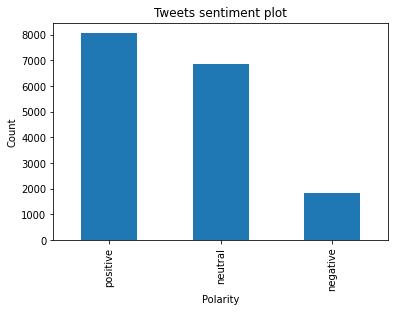

In [12]:
# bar plot of sentiment 
text_data['sentiment'].value_counts().plot(kind="bar")
plt.title("Tweets sentiment plot")
plt.xlabel("Polarity")
plt.ylabel("Count")
plt.show()

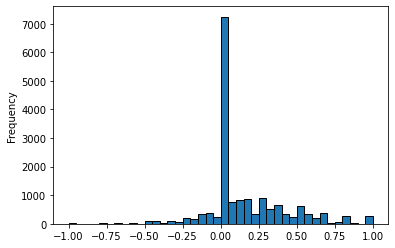

In [13]:
# histogram of polarity score
text_data.polarity.plot(kind='hist',range=(-1,1),bins=40,edgecolor='black');

In [14]:
text_data

,tweets,cleaned_tweets,subjectivity,polarity,sentiment
0,Who loves a good old Stop Hunt from our belove...,love good old stop hunt beloved liquidity prov...,0.60000,0.50000,positive
1,Suddenly a wild bear market appeared...\n\n#bi...,suddenly wild bear market appeared,0.40000,0.10000,positive
2,We give the best signals on binance futures. J...,give best signal binance future join channel e...,0.21250,0.50000,positive
3,@TimmyTimX2 @MXStoken TG https://t.co/AQTHidcD...,tg mx,0.00000,0.00000,neutral
4,@CryptoMichNL my eyes are glued to #HXN @Haven...,eye glued still bullish even path depend marke...,1.00000,1.00000,positive
...,...,...,...,...,...
16752,@WizardDoom Yes to @AnRKeyX's $ANRX in prepara...,yes anrx preparation coming battle wave launch...,0.12500,0.00000,neutral
16753,#BTC is now at $66696.24,,0.00000,0.00000,neutral
16754,#Cryptocurrencies like #Bitcoin are the only o...,like option donate example restricting mean re...,0.74375,0.04375,positive
16755,@intocryptoverse Obviously :) #BTC long is unb...,obviously long unbeatable,0.40000,-0.05000,negative


In [15]:
# combine the original dataset with sentiment score
data_combine = pd.concat([data_clean[['date','user_name','user_followers','user_friends']], text_data],axis=1)

In [16]:
# show the data
data_combine.head(5)

,date,user_name,user_followers,user_friends,tweets,cleaned_tweets,subjectivity,polarity,sentiment
0,2021-10-19 15:20:31,Tino@tradersreality,22061.0,173.0,Who loves a good old Stop Hunt from our belove...,love good old stop hunt beloved liquidity prov...,0.6000,0.5,positive
1,2021-10-21 22:26:28,onemorecomma,227.0,351,Suddenly a wild bear market appeared...\n\n#bi...,suddenly wild bear market appeared,0.4000,0.1,positive
2,2021-07-29 07:02:45,Winners traders,244.0,124.0,We give the best signals on binance futures. J...,give best signal binance future join channel e...,0.2125,0.5,positive
3,2021-08-24 00:58:00,Banks Shilton 💎 Elite 💎,94.0,153.0,@TimmyTimX2 @MXStoken TG https://t.co/AQTHidcD...,tg mx,0.0000,0.0,neutral
4,2021-07-27 08:07:45,Fayenutbutter,253.0,786,@CryptoMichNL my eyes are glued to #HXN @Haven...,eye glued still bullish even path depend marke...,1.0000,1.0,positive


In [17]:
from sklearn.model_selection import train_test_split
tfidf = TfidfVectorizer(analyzer='word')
X_raw = data_combine['cleaned_tweets']
y_raw = data_combine['sentiment']
X_tfidf = tfidf.fit_transform(X_raw)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_raw, test_size=0.2, random_state=42)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word')
X_raw = data_combine['cleaned_tweets']
y_raw = data_combine['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

X_tfidf_train = tfidf.fit_transform(X_train)

from sklearn.ensemble import RandomForestClassifier
# instantiate the clf model
clf = RandomForestClassifier(random_state=42)
# train the model
clf.fit(X_tfidf_train, y_train)

# transform the X_test
X_test_transformed = tfidf.transform(X_test)

# validation
predicted2 = clf.predict(X_test_transformed)

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score2 = accuracy_score(y_test, predicted2)
accuracy_score2

0.9167661097852029

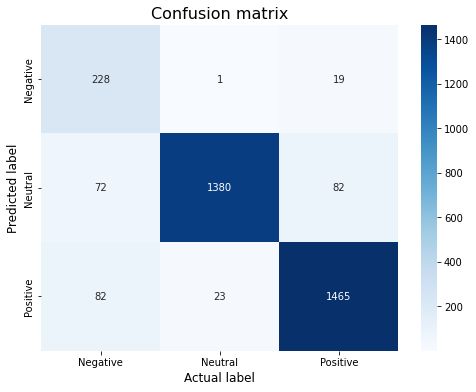

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(y_pred, y_test):
    sentiment_classes = ['Negative','Neutral', 'Positive']
    cm = confusion_matrix(y_pred,y_test)    
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(predicted2, y_test)

In [2]:
from fastparquet import ParquetFile
import pandas as pd

In [3]:
posts = ParquetFile('../data/posts.parquet')

In [4]:
df_posts = posts.to_pandas()

In [5]:
df_posts.head()

,subreddit_subscribers,id,permalink,url,epoch,title,selftext,selftext_html,num_comments,score,downs,ups,upvote_ratio,selftext_clean,date,subreddit
0,4615939,6ej663,/r/Bitcoin/comments/6ej663/mining_in_californi...,https://www.reddit.com/r/Bitcoin/comments/6ej6...,1496276660,Mining in California with the latest S9 is pro...,Like I said this is not a recommendation. I ju...,"<!-- SC_OFF --><div class=""md""><p>Like I said ...",5,7,0,7,0.77,Like I said this is not a recommendation. I ju...,2017-06-01,Bitcoin
1,4615939,6ejbko,/r/Bitcoin/comments/6ejbko/consolidating_utxos...,https://www.reddit.com/r/Bitcoin/comments/6ejb...,1496278312,Consolidating UTXOs vs privacy,"With today's high fees, I decided to combine a...","<!-- SC_OFF --><div class=""md""><p>With today&#...",5,3,0,3,0.64,"With today's high fees, I decided to combine a...",2017-06-01,Bitcoin
2,4615939,6ejctf,/r/Bitcoin/comments/6ejctf/when_will_zuckerber...,https://www.reddit.com/r/Bitcoin/comments/6ejc...,1496278690,When will Zuckerberg announce that he is Satos...,haf thoughts.,"<!-- SC_OFF --><div class=""md""><p>haf thoughts...",3,1,0,1,0.52,haf thoughts.,2017-06-01,Bitcoin
3,4615939,6ejgfj,/r/Bitcoin/comments/6ejgfj/btcchina_resumes_wi...,https://www.reddit.com/r/Bitcoin/comments/6ejg...,1496279813,BTCChina resumes withdraw,daily limit 20btc. I applied and was approved ...,"<!-- SC_OFF --><div class=""md""><p>daily limit ...",41,142,0,142,0.93,daily limit 20btc. I applied and was approved ...,2017-06-01,Bitcoin
4,4615939,6ejhvr,/r/Bitcoin/comments/6ejhvr/betchain_page_5_dir...,https://www.reddit.com/r/Bitcoin/comments/6ejh...,1496280256,BetChain - Page 5 - Direct Casino Support,"Another bitcoin scam, they will not respond af...","<!-- SC_OFF --><div class=""md""><p>Another bitc...",1,2,0,2,0.63,"Another bitcoin scam, they will not respond af...",2017-06-01,Bitcoin


In [6]:
df_sample = df_posts.sample(frac=0.01, replace=True, random_state=1)

In [24]:
datetime.datetime.fromtimestamp(int(1606748238))

datetime.datetime(2020, 11, 30, 9, 57, 18)

In [26]:
class redditSentimentAnalysis:
    def __init__(self, data, stopwords, cryptowords):
        self.data = data
        self.stopwords = stopwords
        self.cryptowords = cryptowords
        self.data_preprocessing()
    
    def data_preprocessing(self):
        data = self.data.dropna(subset=['title','selftext']).reset_index(drop=True)
        data['epoch'] = pd.to_datetime(data['epoch'], unit='s')
        text_data = data[['selftext']].copy()
        text_data['selftext'] = text_data['selftext'].apply(self.text_clean)
        text_data['subjectivity'] = text_data['selftext'].apply(self.getSubjectivity)
        text_data['polarity'] = text_data['selftext'].apply(self.getPolarity)
        text_data = pd.concat([data[['epoch','num_comments','score','upvote_ratio']], text_data],axis=1)
        self.text_data = text_data
        return self.text_data

    def text_clean(self, text):
        #I.  
        #1. Remove urls/hyperlinks
        text = re.sub(r'((www\.[^\s]+)|(http\S+))',' ', text)
        #2. Remove hashtags
        text = re.sub(r'#\w+', ' ', text)
        #3. Remove mentions 
        text = re.sub(r'@\w+',' ', text)
        #4. Remove characters that not in the English alphabets
        text = re.sub('[^A-Za-z]+', ' ', text)
        #5. Remove additional white spaces
        text = re.sub('[\s]+', ' ', text)
        #II. 
        #1. Tokenize
        text = TweetTokenizer().tokenize(text)
        #2. Lower?
        text = [l.lower() for l in text]
        #2. Remove Puncs
        text = [w for w in text if w.isalpha()]
        #3. Removing Stopwords
        lemmatizer = WordNetLemmatizer()
        # Import nltk stopwords and customize it to add common crypto words that don't add too much information 
        text = [t for t in text if t not in (self.stopwords + self.cryptowords)]
        #4. lemmatize
        text = [lemmatizer.lemmatize(t) for t in text]
        #5. Joining

        return " ".join(text)

    def getSubjectivity(self, reddit):
        """
        Create a function to get subjectivity
        Subjectivity is in range [0,1]
        """
        return TextBlob(reddit).sentiment.subjectivity

    def getPolarity(self, reddit):
        """
        create a function to get the polarity
        polarity is in range [-1,1]
        """
        return TextBlob(reddit).sentiment.polarity

In [27]:
from textblob import TextBlob
new_obj = redditSentimentAnalysis(data=df_sample, stopwords=stopwords.words(['english']), cryptowords = ['btc','bitcoin','eth','etherum','crypto'])

In [28]:
new_obj.text_data

,epoch,num_comments,score,upvote_ratio,selftext,subjectivity,polarity
0,2020-11-30 14:57:18,37,111,0.84,ath considered blew past gentleman,0.250000,-0.250000
1,2022-01-05 22:03:53,30,2,0.55,nft make valuable many copy monalisa exist tod...,0.653509,0.208772
2,2018-03-14 21:24:20,6,0,0.42,divided crash united moon killed goose laid go...,0.450397,-0.071032
3,2020-05-31 06:59:23,2,0,0.33,hi old account like legacy segwit moved onto n...,0.444444,-0.066667
4,2017-09-25 18:40:34,0,3,0.80,functional ethereum hype overrated come functi...,0.400000,0.100000
...,...,...,...,...,...,...,...
2987,2021-04-24 00:56:52,89,0,0.50,,0.000000,0.000000
2988,2021-02-03 14:23:06,18,1,1.00,want send coin see forgotten know text documen...,0.071429,0.000000
2989,2017-12-11 06:11:29,5,4,0.66,new whole game upcoming super fork happening m...,0.447964,0.063400
2990,2020-08-29 13:43:17,6,4,0.75,trying understand like many complex thing alwa...,0.577778,0.088889
